# Predicting Spotify Streams: A Supervised Learning Approach

## **Introduction**

This project explores the use of supervised learning techniques to predict the number of streams a song receives on Spotify, based on various features like audio characteristics and chart placement across streaming platforms. Using the "Most Streamed Spotify Songs of 2023" dataset from Kaggle, this notebook walks through the full data science pipeline: from exploratory data analysis (EDA) to model training and evaluation.

The main objective is to build a predictive model that estimates the total Spotify streams a song will accumulate, given input features such as its tempo (BPM), presence in curated playlists, and its energy, acousticness, and danceability levels. Ultimately, this analysis not only serves as an exercise in model evaluation but also offers insights into what makes a song go viral on major streaming platforms.\

Now, let us answer the question of what gives a song a high rate of Spotify streams!


## **Data Overview**
Looking at the dataset, we can see that there are many columns for each observation, from track name and release year to streams and even acousticness percentage! The data itself seems like proper variables to determine whether a song is popular or not.

Below, we load the data and take a quick peek at what we're dealing with.

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')

# Show the first few rows
df.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## **Exploratory Data Analysis (EDA)**

Now is the time can start playing with the data itself! Though this step is for me to make sure the data is clean enough for processing and model building. Thus, we begin with data preprocessing. Afterwards, we can do some analysis on the data to see if there are any significant features to base our model on.

In [2]:
# Shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of the dataset
df.info()


Dataset contains 953 rows and 24 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15

#### **Missing/Incorrect Data Type Handling**

When printing out the info of the dataframe we loaded, it is apparent that we are dealing with some issues. If we started with a clean dataset, we would see all columns contain non-null values; however, when printing 'df.info()', we can see that 'in_shazam_charts' and 'key' do not contain 953 (the total number of rows) non-null values, they contain 903 and 858 values, respectively.

Another thing, when looking at the Dtype for 'streams', 'in_deezer_playlists', and 'in_shazam_charts', it can be noted that instead of being integers, they are instead objects. When taking a look at why this is the case, I came across these examples:

Line 576's ("Love Grows (Where My Rosemary Goes)") 'stream value': BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3

Line 405's (One Kiss (with Dua Lipa)) 'in_deezer_playlists' value:
"2,726"

Line 14's (Flowers) 'in_shazam_charts' value:
"1,021"

As shown above, these are not integer values. Thankfully, we can save a good portion of the data that displays their integer in standard (thousands separator) form with some logic below. However, with the observations that contain null values and a singular incorrect 'streams' variable, I can either create best estimators for respective incorrect/missing values or remove the observations from the dataset.

Whether I choose to drop rows or impute the data, there will be a possibility of creating bias. So in this exercise, I will simply drop the null valued observations after dealing with the integer mishap.


In [3]:
# Loop over each column to remove unnecessary characters
for col in ['streams', 'in_deezer_playlists', 'in_shazam_charts']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace('"', '').str.replace(',', ''), errors='coerce')

# Drop rows with NaNs in those columns
df.dropna(subset=['streams', 'in_deezer_playlists', 'in_shazam_charts', 'key'], inplace=True)

# Convert to int
df['streams'] = df['streams'].astype(int)
df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
df['in_shazam_charts'] = df['in_shazam_charts'].astype(int)

df.reset_index(drop=True, inplace=True)

# Double-check the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            816 non-null    object
 1   artist(s)_name        816 non-null    object
 2   artist_count          816 non-null    int64 
 3   released_year         816 non-null    int64 
 4   released_month        816 non-null    int64 
 5   released_day          816 non-null    int64 
 6   in_spotify_playlists  816 non-null    int64 
 7   in_spotify_charts     816 non-null    int64 
 8   streams               816 non-null    int64 
 9   in_apple_playlists    816 non-null    int64 
 10  in_apple_charts       816 non-null    int64 
 11  in_deezer_playlists   816 non-null    int64 
 12  in_deezer_charts      816 non-null    int64 
 13  in_shazam_charts      816 non-null    int64 
 14  bpm                   816 non-null    int64 
 15  key                   816 non-null    ob

### **Note**

As shown, the dataset took a major hit. There was a loss of 137 samples, which can be a source of bias and loss of statistical power. This is something I **need** to keep in mind while moving forward.

In [4]:
# Summary stats for numerical columns
df.describe()


,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,8.160000e+02,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000
mean,1.568627,2018.517157,6.024510,13.712010,4852.316176,11.736520,4.689858e+08,60.215686,49.534314,372.053922,2.454657,57.622549,122.580882,67.409314,51.172794,64.356618,26.333333,1.678922,18.170343,10.535539
std,0.876522,10.701973,3.570415,9.294719,7745.565488,18.624555,5.231267e+08,74.953565,49.570536,1157.759053,5.399650,153.616316,28.188643,14.688808,23.620742,16.116646,25.477606,8.772508,13.550239,10.222852
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2021.000000,3.000000,5.000000,829.000000,0.000000,1.342848e+08,12.000000,6.000000,12.750000,0.000000,0.000000,99.000000,57.000000,32.000000,53.000000,5.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,5.000000,13.000000,2037.500000,3.000000,2.638368e+08,32.000000,34.500000,39.000000,0.000000,3.000000,120.000000,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,4890.750000,16.000000,6.011986e+08,78.250000,84.000000,142.250000,2.000000,38.250000,141.250000,79.000000,70.000000,76.000000,41.000000,0.000000,24.000000,12.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.562544e+09,532.000000,275.000000,12367.000000,45.000000,1451.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


Due to there being a high variation of values in 'track_name', 'artist(s)', and 'url', I decided to drop those values as well. My detailed reasons for dropping each are shown below below:

'track_name' - Though a particular song may prove to be popular, there are many different track names that may never align. Even then, their 'streams' values should not be a direct correlation due to there being a hidden variable that will better determine a song's 'streams' value.

'artist(s)' - While this variable can directly determine the reasoning a song has a low or high 'streams' count due to how popular an artist is, there are different 'artist(s)' values that will include the artist's name, but fail to be taken into account of because they are featured, contain a feature, or are paired with with other artists. For example, when looking at *The Weeknd*:

Line 618's (Take My Breath) 'artist(s)' value: "The Weeknd"
Line 26's (Popular (with Playboi Carti & Madonna) - The Idol Vol. 1 (Music from the HBO Original Series)) 'artist(s)' value: "The Weeknd, Madonna, Playboi Carti"
Line 566's (You Right) 'artist(s)' value: "Doja Cat, The Weeknd"

*The Weeknd* as a value will not be treated for the observations in Lines 26 and 566, as well as any other row where he is noted as a co-artist.

'url' - This field provides the same amount of information on streams as 'track_name' would; it solely depends on different values.

As a result of these findings, I will proceed to drop said columns before performing more analysis.


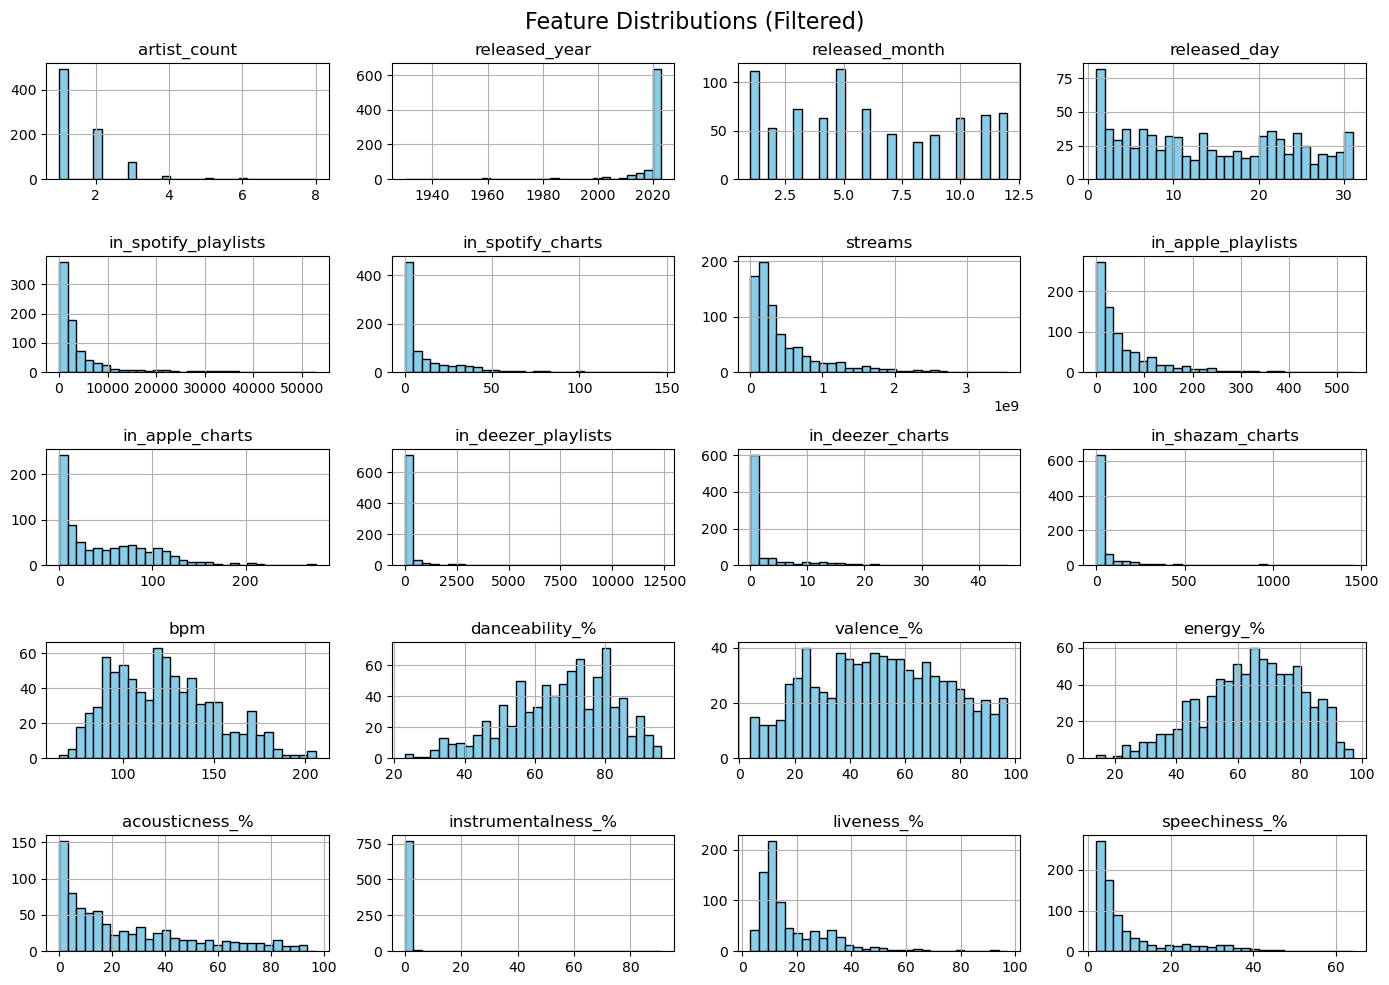

In [5]:
# Define columns to exclude (like non-numeric, identifiers, or irrelevant)
exclude_cols = ['track_name', 'artist(s)', 'url']

# Build a list of numeric columns, excluding the ones you don't want
plot_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

# Plot histograms
df[plot_cols].hist(figsize=(14, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions (Filtered)', fontsize=16)
plt.tight_layout()
plt.show()

Above are the distribustions of each data set after cleaning the data. Now to look at how these data points correlate with one another as well as with the 'streams' values.

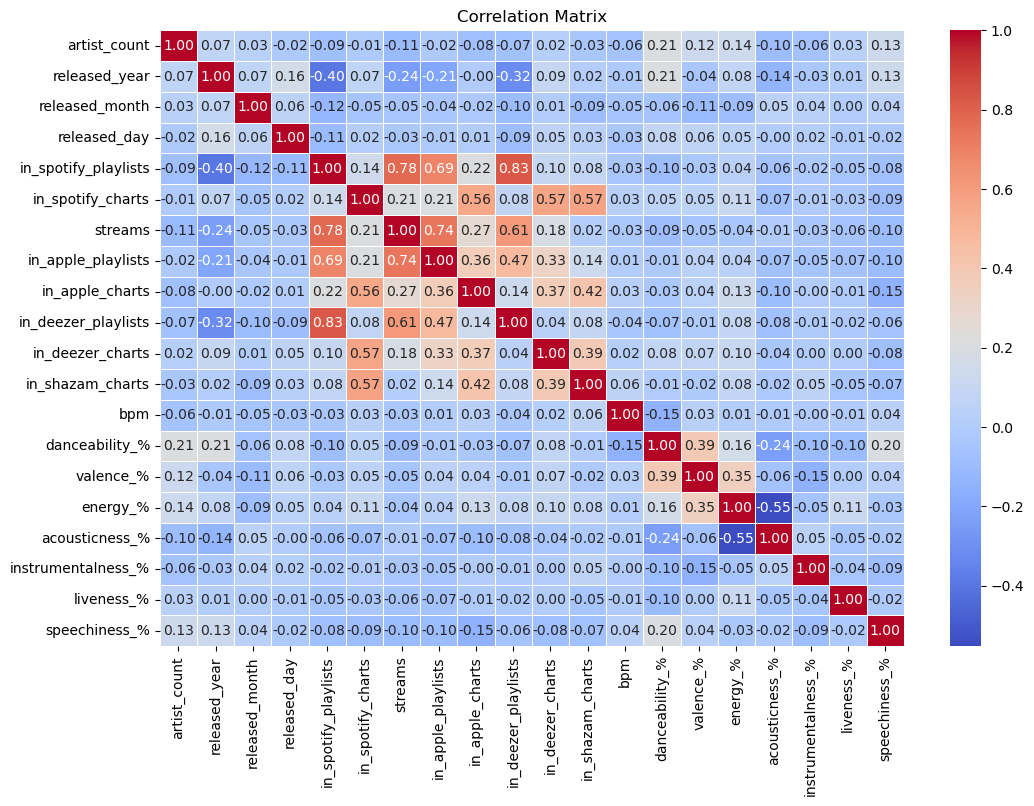

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df[plot_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


As shown above, there is a warm region around the fields 'in_spotify_playlists' and 'in_shazam_charts'. There is also a moderately negative correlation between 'energy_%' and 'acousticness'. Though we are looking at the correlation between 'streams' and other columns, we can ignore 'energy%' and 'acousticness_%'.

It appears that 'in_spotify_playlists', 'in_apple_playlists', and 'in_apple_playlists' all have a moderately strong positive correlation with 'streams'. To further look into these trends, I went ahead and looked at the 'in_..._playlist' versus 'streams' graphs to better visualize what I am dealing with.

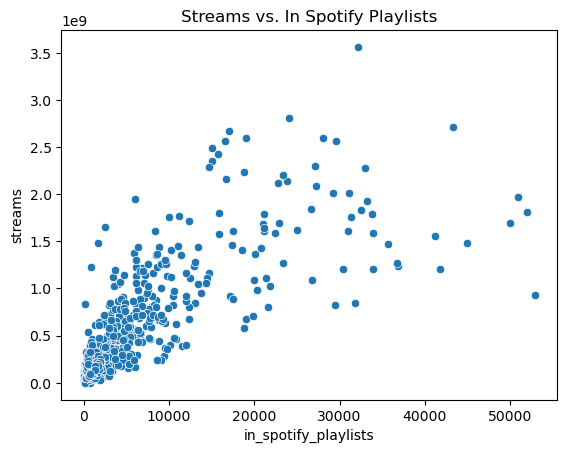

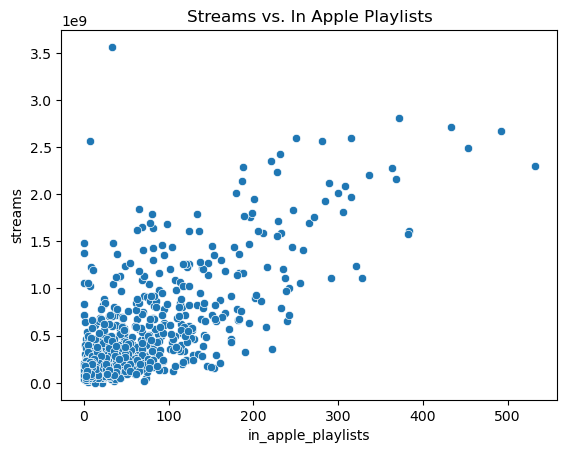

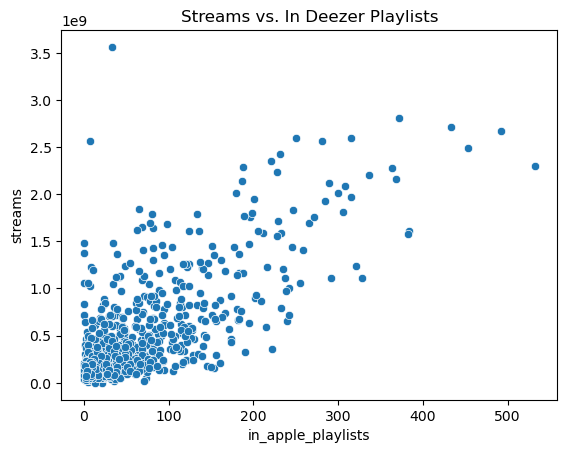

In [7]:
# Spotify Playlists vs Streams
sns.scatterplot(data=df, x='in_spotify_playlists', y='streams')
plt.title('Streams vs. In Spotify Playlists')
plt.show()

# Apple Playlists vs Streams
sns.scatterplot(data=df, x='in_apple_playlists', y='streams')
plt.title('Streams vs. In Apple Playlists')
plt.show()

# Deezer Playlists vs Streams
sns.scatterplot(data=df, x='in_apple_playlists', y='streams')
plt.title('Streams vs. In Deezer Playlists')
plt.show()


#### **NOTE**
It appears that the 'in_..._playlist' features all have the highest correlation with 'streams'. This can create an issue, multicollinearity. To solve this, I can either lower the dimensionality by combining all three features or choose a model that can handle multicollinearity well...

So, why not do both? For the last remaining segment of my data preprocessing, I shall combine the features into one for a simple linear regression model and keep them separate for a random forest model.

Here we combine the features for the next step, model building/testing.


In [8]:
# Combine playlist features into a single column
df['playlist_exposure'] = (
    df['in_spotify_playlists'] +
    df['in_apple_playlists'] +
    df['in_deezer_playlists']
)


## **Model Building and Testing**

Now for the fun part, where we build and deploy our models in a testing environment. As mentioned previously, I will be building two different models to determine how they perform: a lowered dimensionality linear regression or a random forest that keeps the features separate.

To start off, I define my features, label, and split the observations.

#### **Note**
I plan on using today's date (April 19th, 2025) for the 'random_state' parameter, just in case someone would like to redo my testing environment.


In [9]:
# Label
label = 'streams'
y = df[label]

# Feature sets
combined_features = ['playlist_exposure']
separate_features = ['in_spotify_playlists', 'in_apple_playlists', 'in_deezer_playlists']
X_comb, X_sep = df[combined_features], df[separate_features]

# Split the observations
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_comb, y, test_size=0.2, random_state=4192025)
X_sep_train, X_sep_test, y_sep_train, y_sep_test = train_test_split(X_sep, y, test_size=0.2, random_state=4192025)

Now to build each model as well as test their performance.

In [10]:
# Create and predict the values for Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_comb_train, y_comb_train)

y_pred_lr = lr_model.predict(X_comb_test)

print("Linear Regression (Combined Feature)")
print("RMSE:", np.sqrt(mean_squared_error(y_comb_test, y_pred_lr)))
print("R²:", r2_score(y_comb_test, y_pred_lr))


Linear Regression (Combined Feature)
RMSE: 358365043.9812979
R²: 0.5278142116540608


In [11]:
# Create and predict the values for Random Forest
rf_model = RandomForestRegressor(random_state=4192025)
rf_model.fit(X_sep_train, y_sep_train)

y_pred_rf = rf_model.predict(X_sep_test)

print("Random Forest (Separate Features)")
print("RMSE:", np.sqrt(mean_squared_error(y_sep_test, y_pred_rf)))
print("R²:", r2_score(y_sep_test, y_pred_rf))


Random Forest (Separate Features)
RMSE: 265813122.66845468
R²: 0.740214764351911


#### **Bonus: Hyperparameter Tuning for Random Forest**

I wanted to take it a step further and see just how much better we can make R². By finding the optimal parameters for hypertuning with GridSearchCV, I aim to see if we can make my RandomForestRegresser() model just a little better. 

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt']
}

rf = RandomForestRegressor(random_state=4192025)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,              
    cv=3, 
    n_jobs=-1, 
    verbose=1, 
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(X_sep_train, y_sep_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 259047527.32876244


In [13]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    random_state=4192025
)
rf_model.fit(X_sep_train, y_sep_train)

y_pred_best = rf_model.predict(X_sep_test)

print("Random Forest (Separate Features)")
print("RMSE:", np.sqrt(mean_squared_error(y_sep_test, y_pred_best)))
print("R²:", r2_score(y_sep_test, y_pred_best))


Random Forest (Separate Features)
RMSE: 264035953.31084585
R²: 0.7436768884281086


Although the hyperparameter tuning did not increase R² by much, it still boosted it in the right direction.

## **Model Evaluation**

As shown above, it can be seen that Random Forests were able to better handle the multicollinearity than Linear Regression (even when reducing the dimensionality!). Where Linear Regression had an R² of ≈0.528, Random Forests had an R² of ≈0.0.744 (in the best case scenario).

Below, I further analyze each model in a predicted versus actual graph as well as an evaluation, based on RMSE, NRMSE, MAE, MAE-to-Mean Ratio (which I will refer to as MAE/Mean), and R².

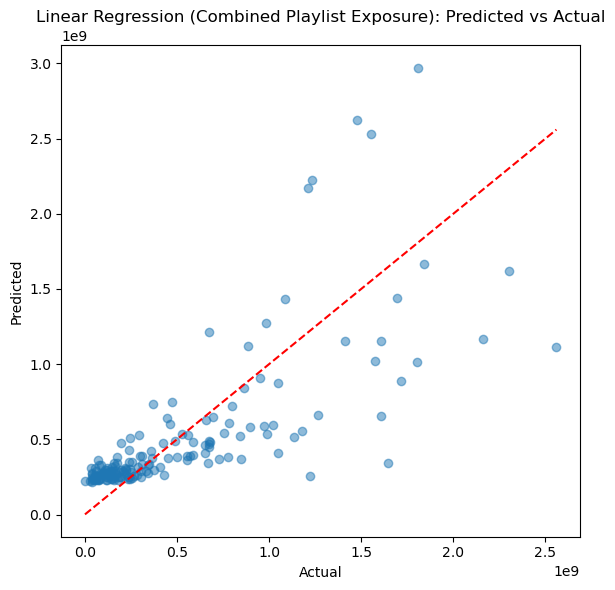

Linear Regression (Combined Playlist Exposure) Performance:
   RMSE:     358365043.98
   NRMSE:    0.10059253524533568
   MAE:      240131233.58
   MAE/Mean: 0.512022436072116
   R²:       0.5278


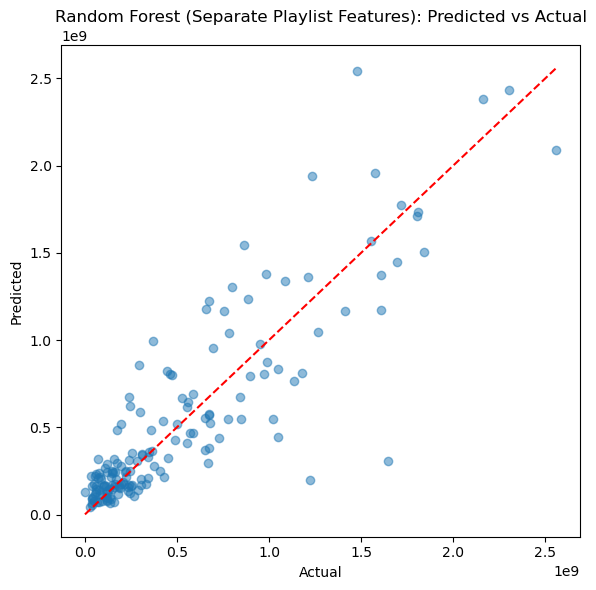

Random Forest (Separate Playlist Features) Performance:
   RMSE:     265813122.67
   NRMSE:    0.0746133484829918
   MAE:      173034276.23
   MAE/Mean: 0.3689542185816623
   R²:       0.7402


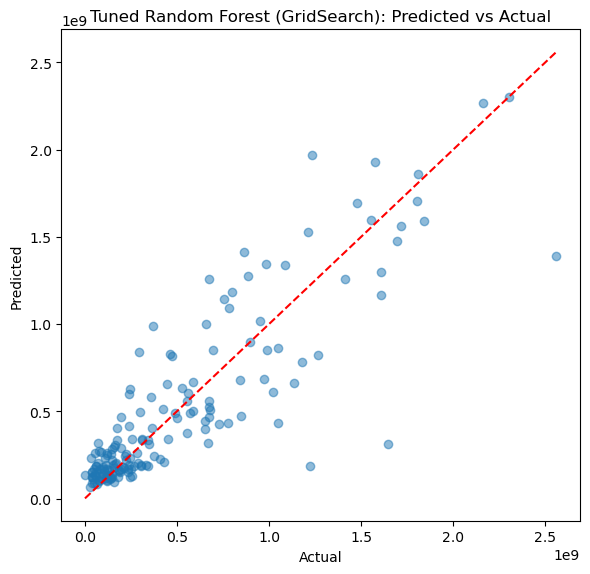

Tuned Random Forest (GridSearch) Performance:
   RMSE:     264035953.31
   NRMSE:    0.0741144996855306
   MAE:      171553457.42
   MAE/Mean: 0.36579672654562106
   R²:       0.7437


In [14]:
# Plots the predictions in a predicted vs actual graph
def plot_predictions(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.tight_layout()
    plt.show()

# Evaluates each model with RMSE, MAE, and R²
def evaluate_model(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"   RMSE:     {rmse:.2f}")
    print(f"   NRMSE:    {rmse / (df['streams'].max() - df['streams'].min())}")
    print(f"   MAE:      {mae:.2f}")
    print(f"   MAE/Mean: {mae / df['streams'].mean()}")
    print(f"   R²:       {r2:.4f}")

# Display a predicted vs actual graph for each model as well as their respective RMSE, MAE, and R²
plot_predictions(y_comb_test, y_pred_lr, "Linear Regression (Combined Playlist Exposure)")
evaluate_model(y_comb_test, y_pred_lr, "Linear Regression (Combined Playlist Exposure)")

plot_predictions(y_sep_test, y_pred_rf, "Random Forest (Separate Playlist Features)")
evaluate_model(y_sep_test, y_pred_rf, "Random Forest (Separate Playlist Features)")

plot_predictions(y_sep_test, y_pred_best, "Tuned Random Forest (GridSearch)")
evaluate_model(y_sep_test, y_pred_best, "Tuned Random Forest (GridSearch)")

#### **Evaluations**

Here is what to look for from the observations above:

RMSE (Root Mean Squared Error) - This metric is an accuracy metric that places a **hard** penalty on outliers. So long as this value is significantly lower than the standard deviation, then that can be a sanity check on where your model is in terms of accuracy (recalling the standard deviation for 'streams', the value is approximately 523,126,700).

NRMSE (Normalized Root Mean Squared Error) - A similar metric to RMSE, but it deals with the proportion of the variability in the observed data that the model captures. Thus, a lower percentage equates to a more accurate model when compared to a model with a higher percentage, which is less accurate. This value takes the RMSE and divides it by the range of 'streams'

MAE (Mean Absolute Error): This statistic indicates how far off, on average, a predictor is from the actual. Which makes this metric another sanity check on the accuracy of one's model. Now, we try to shoot for zero, but that is rarely the case in the real world. So when looking at our data, we see a range of values from the tens of thousands up to the billions. Thus, we must account for that when looking at the MAE for each model.

MAE/Mean (MAE-to-Mean Ratio): This metric aims to serve as support for MAE, showing how big the errors are compared to the average number of streams. Ideally, the ratio should not be 1:1, or else the model needs to be scrapped entirely. So, like the NRMSE, I am seeking a lower percentage (with some leeway) to determine the model's performance.

R² (Coefficient of Determination): This statistic shows the proportion of the variation in the dependent variable that is predictable from the independent variable. Thus, we would prefer to see this number as close to 1 (or -1) as possible to say the model is a good predictor for 'streams'. Since we are only dealing with positively correlating relationships, we only want to see the coefficient as close to 1 as possible.


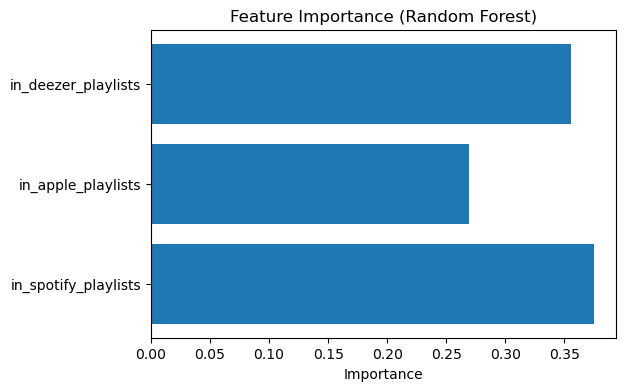

In [15]:
importances = rf_model.feature_importances_
features = X_sep.columns

plt.figure(figsize=(6,4))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()


Looking at the importance of each feature, it is show that 'in_spotify_playlist' was of most importance in the evaluation of each sample. Though the variations in feature importance did not vary much.

## **Results & Discussion**

Among all the models tested, the tuned Random Forest Regressor outperformed all others. Here's a quick comparison:

- **Tuned Random Forest**  
  RMSE: 264,035,953  
  MAE: 171,553,457  
  R²: 0.7437

- **Untuned Random Forest (Separate Playlist Features)**  
  RMSE: 265,813,123  
  MAE: 173,034,276  
  R²: 0.7402

- **Linear Regression (Combined Playlist Exposure)**  
  RMSE: 358,365,044  
  MAE: 240,131,234  
  R²: 0.5278

The significant drop in performance when using linear regression suggests that the relationships between features and Spotify streams are highly non-linear and likely include interactions between different types of chart placements and song features. The Random Forest models, especially the tuned one, were able to capture these complexities effectively.

An important insight was that individual playlist/chart features (like 'in_spotify_playlists' and 'in_apple_playlists') strongly correlate with stream counts. Combining them into a single "exposure" score reduced model performance, indicating valuable predictive power in keeping them separate.


## **Conclusion**

This project demonstrates how supervised learning methods, especially tree-based models like Random Forests, can be effectively used to predict music streaming success. We explored different modeling approaches and found that treating playlist appearances separately yields better performance than combining them into a single feature. The tuned Random Forest model provided the best results, explaining about 74% of the variance in stream counts.

Future work could explore deeper models like XGBoost or neural networks, log-transforming the target variable to handle skewness, or incorporating additional external metadata such as artist popularity or genre.

Below is a short list of what worked and what did not work:


What Worked

- The 'in_spotify_playlists', 'in_apple_playlists', and 'in_deezer_playlists' features were strongly correlated with 'streams', and served as effective predictors.

- Random Forests performed better than Linear Regression, especially when the playlist features were kept separate.

- Hyperparameter tuning improved the RMSE and R², showing that the model could better generalize after fine-tuning.

What Didn’t Work

- Song characteristics like 'danceability_%', 'energy_%', 'valence_%', etc. had weak linear correlation with streams. These features may still help in a non-linear model, but alone weren’t useful.

- Linear Regression underperformed because of multicollinearity and the non-linear nature of some relationships.

- The raw 'streams' data was heavily skewed — without a log transformation, most models struggled to make sense of the scale.

## **References**
- Dataset source: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data